<center>
    <h1>Assignment 1 - Recurrent Neural Models for Sequence Labeling</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it; enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`. Before reading this notebook, see the notebook `1) oov handling.ipynb`.

In this notebook, the POS tagging task is addressed.

To run this notebook, the following data should be present in the rigth folders.
- The dataset should be put inside the `dataset` folder. Link to the dataset: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
- The extended $100$ dimensional GloVe embedding model `extended_glove.100d.txt` should be put inside the `glove_pretrained` folder. This embedding model has been obtained by running the previous notebook.

The training of the models is not necessary, since their weigths are present inside the `weigths` folder. Thus, the reader can skip the training phases and go straight into the evaluation and error analysis section.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

In [1]:
import os 
import random  

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Settings fro autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reprodicibility

seed = 41

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 1 Preliminaries

## 1.1 Dataset loading

The training, validation and test datasets are loaded, splitting the documents into sentences. Each dataset has the form `(texts, labels)`, where the former is a list of list of strings, representing the sentences words, while the latter is a list of list of strings, representing the corresponding sentences POS tags.

As preprocessing, all the words are trasformed into lowercase. Moreover, all the numbers are substituted with the same special token `[num]`. The idea is that almost all of them have the same POS tag, i.e. `CD` Cardinal Numbers, therefore they are equivalent from the POS tagging perspective.

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True,
                                                                                                group_numbers=True)

print(f'Number of training sentences: {len(texts_train)}')
print(f'Number of validation sentences: {len(texts_val)}')
print(f'Number of test sentences: {len(texts_test)}')


Number of training sentences: 1959
Number of validation sentences: 1277
Number of test sentences: 638


## 1.2 Vocabulary creation

The vocabulary, i.e. mapping from integers ids into words, is created from the whole corpus train+val+test. The integer id $0$ is reserved for the special padding token `''`. 

Moreover, the words in the train-val-test texts are trasformed into the corresponding integers, producing the datasets `x_train`-`x_val`-`x_test`, which are represented as list of list of integers. It is important to point out that no padding is performed yet.

In [5]:
from utils.vocabulary_builder import create_vocabulary

texts = texts_train + texts_val + texts_test

vocabulary, x = create_vocabulary(texts=texts)

x_train, x_val, x_test = (x[0:len(texts_train)], x[len(texts_train):len(texts_train)+len(texts_val)],
                                                    x[len(texts_train)+len(texts_val):])

The same procedure is now applied for the labels. The `vocabulary_labels` is created, which is a mapping from integers ids into POS tags. Also here, the integer $0$ is reserved for the special padding POS tag. Finally, the list of list of integers `y_train`-`y_val`-`y_test` are created (which are not padded).

The following POS tags are considered as punctuation: `[',', '.', ':', '``', "''", '$', '-RRB-', '-LRB-', '#', 'LS', 'SYM']`. Overall, the tags to not evaluate are the punctuation tags plus the padding tag `''`.

In [6]:
from utils.vocabulary_builder import create_vocabulary

labels = labels_train + labels_val + labels_test

vocabulary_labels, y = create_vocabulary(texts=labels)

y_train, y_val, y_test = (y[0:len(labels_train)], y[len(labels_train):len(labels_train)+len(labels_val)],
                                                    y[len(labels_train)+len(labels_val):])

# The number of different POS tags
n_classes = len(vocabulary_labels)

# The punctuation POS tags
punctuation_tags = [',', '.', ':', '``', "''", '$', '-RRB-', '-LRB-', '#', 'LS', 'SYM']
# POS tags to not evaluate: punctuation tags + padding
tags_no_evaluate = punctuation_tags + ['']

## 1.3 Data Generator

The training and validation data generators are now built. The purpose of a Data Generator is to generate batches of samples, which will be used during training. The padding is performed batch-wise: each batch is padded separately, according to the maximum sequence length inside it. While the training generator is defined such that it shuffles the data before each epoch, the validation generator does not perform any shuffling.  

In [7]:
from utils.data_generator import DataGenerator

train_gen = DataGenerator(tokens=x_train, labels=y_train)

val_gen = DataGenerator(tokens=x_val, labels=y_val, shuffle=False)

Moreover, the padded versions of the whole validation and test datasets are created, which will be used for evaluating the models. 

In [8]:
x_val_padded, y_val_padded = DataGenerator(tokens=x_val, labels=y_val, batch_size=len(x_val), shuffle=False)[0]
x_test_padded, y_test_padded = DataGenerator(tokens=x_test, labels=y_test, batch_size=len(x_test), shuffle=False)[0]
print(f'x_val_padded shaped: {x_val_padded.shape}')
print(f'x_test_padded shaped: {x_test_padded.shape}')

x_val_padded shaped: (1277, 80)
x_test_padded shaped: (638, 80)


## 1.4 Analysis of the training set
In this section some interesting analyses on the training set are carried out. Very similary results can be obtained also on the validation and test sets, therefore these plots are omitted for simplicity.

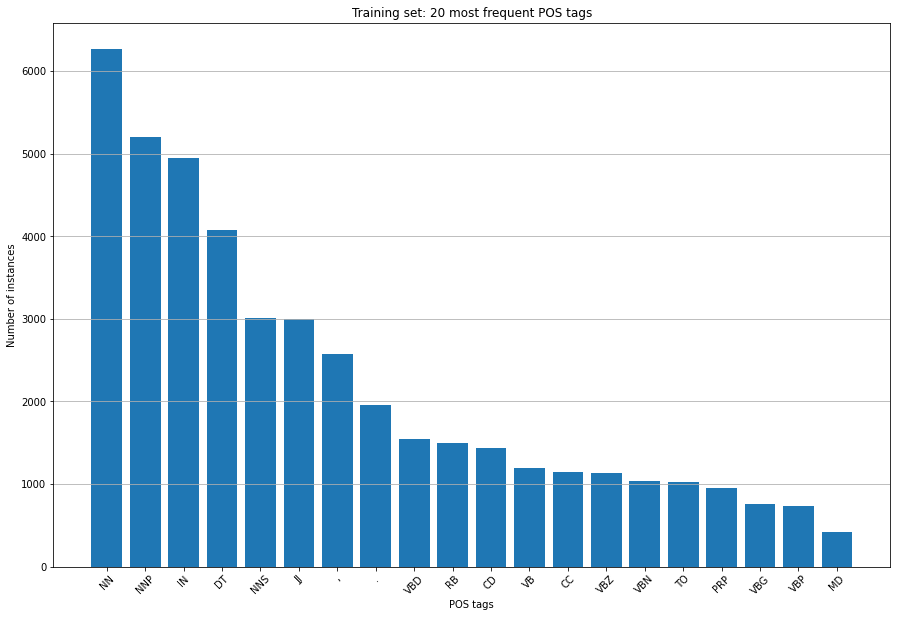

In [9]:
from utils.dataset_analysis import most_frequent_tokens_analysis 

labels_counts_dict = most_frequent_tokens_analysis(texts=labels_train, plot=True, xlabel='POS tags', title='Training set: 20 most frequent POS tags')

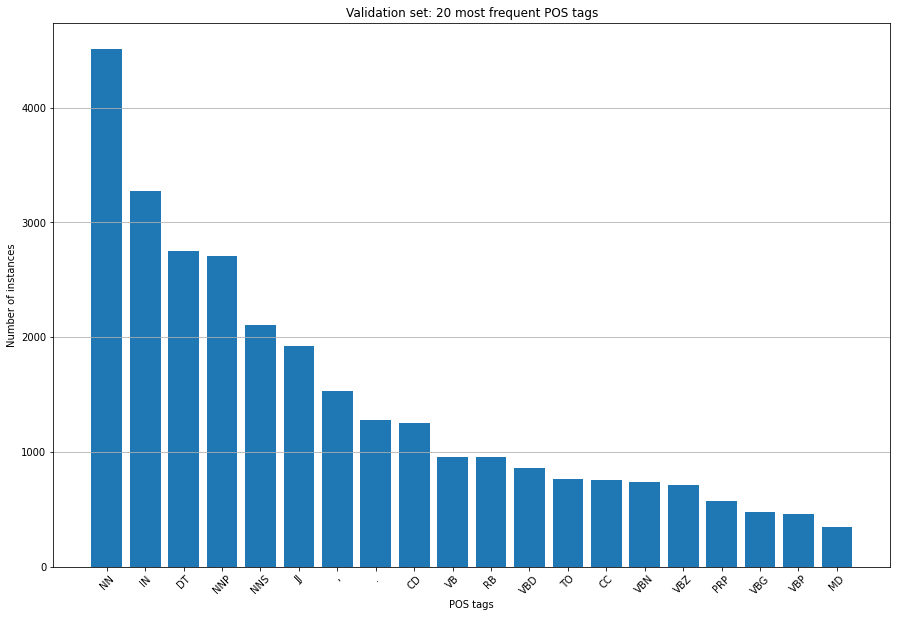

In [10]:
from utils.dataset_analysis import most_frequent_tokens_analysis 

labels_counts_dict = most_frequent_tokens_analysis(texts=labels_val, plot=True, xlabel='POS tags', title='Validation set: 20 most frequent POS tags')

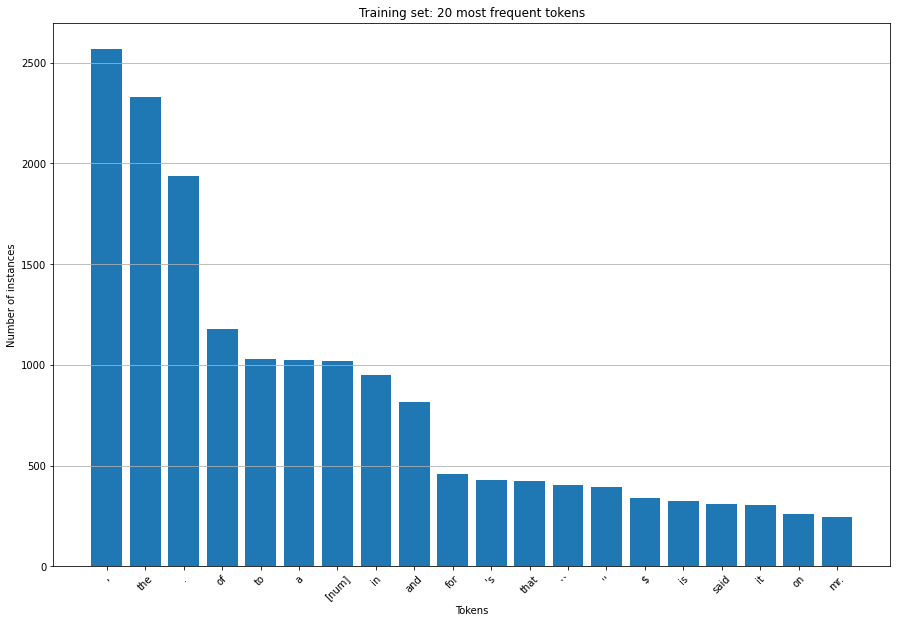

In [11]:
from utils.dataset_analysis import most_frequent_tokens_analysis 

tokens_counts_dict = most_frequent_tokens_analysis(texts=texts_train, plot=True, title='Training set: 20 most frequent tokens')

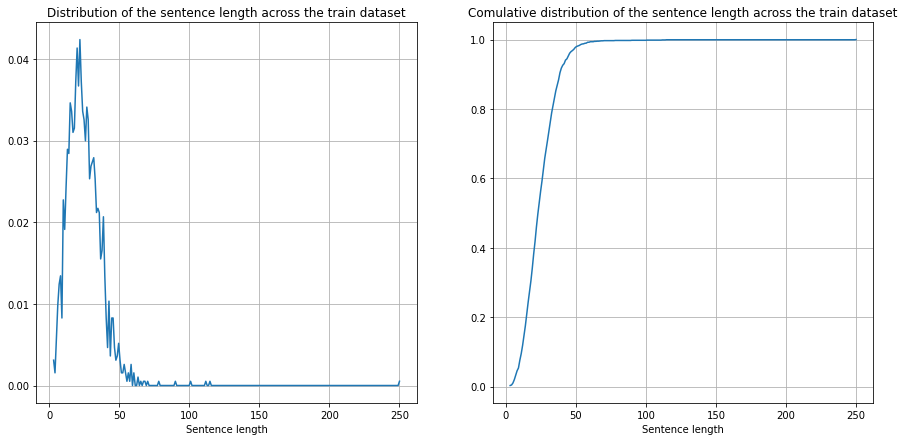

In [12]:
from utils.dataset_analysis import plot_sequence_length_analysis

plot_sequence_length_analysis(texts=texts_train)

## 1.5 Glove embeddings

The embedding model, which is the **extended GloVe embedding** in this case, is loaded, using $100$ as embedding dimension. The embedding model is implemented as a dictionary from words to the corresponding embedding vectors.

The extended GloVe embedding is the GloVe embedding which has been expanded with the training-validation-test OOV words.

In [13]:
from utils.embedding_model_handler import load_embedding_model

embedding_dimension = 100

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension, extended_version=True)

In [14]:
print(f'Embedding model size: {len(GLOVE_embeddings)}')  

Embedding model size: 400539


## 1.6 Embedding matrix

The embedding matrix, i.e. matrix whose rows correspond to the different corpus tokens and which contain the correspoding embedding vectors, is built.

In [15]:
from utils.embedding_matrix_builder import build_embedding_matrix

embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, 
                                          embedding_dimension=embedding_dimension)

## 1.7 Training callbacks

Finally, the training callbacks are defined, which will be used for the training of the different models.
- Early stopping
- Reduce LR on Plateau

In [16]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=4,
                                            min_delta=1e-3,
                                            restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_delta=1e-3)

# 2 Models
In this section, the different considered models are illustrated.

## 2.1 First dummy classifier: majority class
We define a dummy classifier, which always returns as predicted POS tag the most frequent POS tag present in the training set. This classifier is used for getting a sense of the most basic baseline score.

In [45]:
most_common_label = list(labels_counts_dict.keys())[0]
most_common_label_index = np.where(vocabulary_labels==most_common_label)[0][0]
print(f'Most common POS tag ==> label : {most_common_label}; index : {most_common_label_index}')

Most common POS tag ==> label : NN; index : 1


In [46]:
# Validation f1-score

from utils.evaluate import compute_f1_score

y_pred_val = np.array([[most_common_label_index for _ in range(y_val_padded.shape[1])] for _ in range(y_val_padded.shape[0])])

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.008


## 2.2 Baseline Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. a final time-distributed dense layer, producing the output.

The output layer does not use any activation function, since the `SparseCategoricalCrossentropy(from_logits=True)` loss function is used.

The `Adam` optimizer is used, with default LR, i.e. $0.001$.

We tuned different values for the hyperparameters `latend_dim` and `dropout` of the LSTM layer. The values `latend_dim=128` and `dropout=0.2` turned out to be the best one, according to the validation f1-score.

In [22]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [23]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1006100   
                                                                 
 bidirectional (Bidirectiona  [(None, None, 256),      234496    
 l)                           (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 time_distributed (TimeDistr  (None, None, 46)         11822     
 ibuted)                                                         
                                                             

In [24]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'baselineModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsBaselineModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Training

In [22]:
baseline_model_history = baseline_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 20s 160ms/step - loss: 2.4266 - accuracy: 0.3989 - val_loss: 1.5733 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 101ms/step - loss: 1.1685 - accuracy: 0.7074 - val_loss: 0.9000 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 7s 109ms/step - loss: 0.7889 - accuracy: 0.7932 - val_loss: 0.6877 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 9s 152ms/step - loss: 0.6407 - accuracy: 0.8289 - val_loss: 0.5866 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 7s 108ms/step - loss: 0.5574 - accuracy: 0.8449 - val_loss: 0.5232 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 101ms/step - loss: 0.5041 - accuracy: 0.8587 - val_loss: 0.4804 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 103ms/step - l

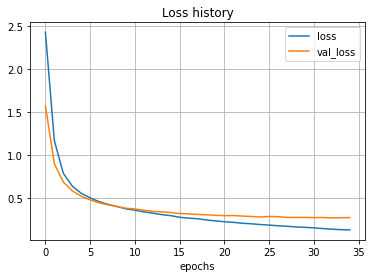

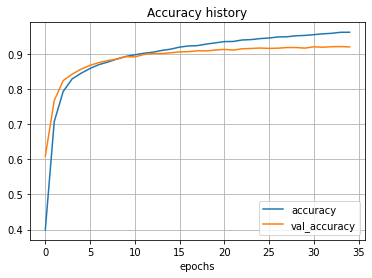

In [24]:
from utils.utils import plot_history

plot_history(baseline_model_history)

#### Example of predictions on a val sentence

In [27]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(baseline_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NN IN JJ JJ NN CC NN .


#### Validation f1-score macro (no punctuation)

In [47]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

baseline_model.load_weights('weigths/baselineModel/weightsBaselineModel.34-0.27.hdf5')

In [48]:
y_pred_val = np.argmax(baseline_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.801


## 2.3 First Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional GRU layer;
4. a final time-distributed dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters `latent_dim` and `dropout` have been obtained. 

In [18]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [36]:
first_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         1006100   
                                                                 
 bidirectional_2 (Bidirectio  [(None, None, 256),      176640    
 nal)                         (None, 128),                       
                              (None, 128)]                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 46)         11822     
 tributed)                                                       
                                                                 
Total params: 1,194,562
Trainable params: 188,462
Non-trainable params: 1,006,100
___________________________________________

In [34]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'firstModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsFirstModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Training

In [35]:
first_model_history = first_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 23s 160ms/step - loss: 2.1391 - accuracy: 0.4614 - val_loss: 1.1708 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 97ms/step - loss: 0.8847 - accuracy: 0.7716 - val_loss: 0.7046 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 6s 95ms/step - loss: 0.6273 - accuracy: 0.8288 - val_loss: 0.5611 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 6s 95ms/step - loss: 0.5278 - accuracy: 0.8504 - val_loss: 0.4871 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 6s 91ms/step - loss: 0.4663 - accuracy: 0.8661 - val_loss: 0.4422 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 91ms/step - loss: 0.4254 - accuracy: 0.8790 - val_loss: 0.4262 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 5s 86ms/step - loss: 0

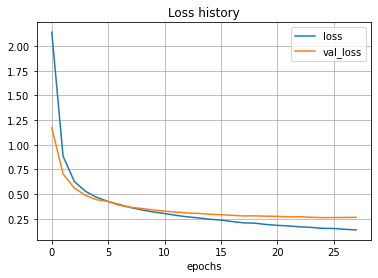

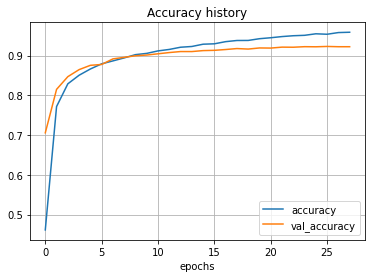

In [37]:
from utils.utils import plot_history

plot_history(first_model_history)

#### Example of predictions on a val sentence

In [39]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(first_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NNS IN NNP WDT VBZ VBN IN $ CD CD IN NN CC NN NN IN JJ CD IN NN IN VBG JJ NN CC NN .


#### Validation f1-score macro (no punctuation)

In [49]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

first_model.load_weights('weigths/firstModel/weightsFirstModel.26-0.26.hdf5')

In [50]:
from utils.evaluate import compute_f1_score

y_pred_val = np.argmax(first_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.813


## 2.4 Second Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. another Bidirectional LSTM layer;
4. a final time-distributed  dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters `latent_dim` and `dropout` have been obtained. 

In [67]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [68]:
second_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_12 (Embedding)    (None, None, 100)         1006100   
                                                                 
 bidirectional_15 (Bidirecti  [(None, None, 256),      234496    
 onal)                        (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 bidirectional_16 (Bidirecti  [(None, None, 256),      394240    
 onal)                        (None, 128),                       
                              (None, 128),                

In [69]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'secondModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsSecondModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Training

In [70]:
second_model_history = second_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 38s 368ms/step - loss: 2.5657 - accuracy: 0.3039 - val_loss: 1.6867 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 17s 271ms/step - loss: 1.1982 - accuracy: 0.6787 - val_loss: 0.8501 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 17s 288ms/step - loss: 0.7574 - accuracy: 0.7949 - val_loss: 0.6295 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 27s 442ms/step - loss: 0.6050 - accuracy: 0.8306 - val_loss: 0.5281 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 32s 527ms/step - loss: 0.5241 - accuracy: 0.8505 - val_loss: 0.4611 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 19s 314ms/step - loss: 0.4648 - accuracy: 0.8658 - val_loss: 0.4158 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 17s 285ms/st

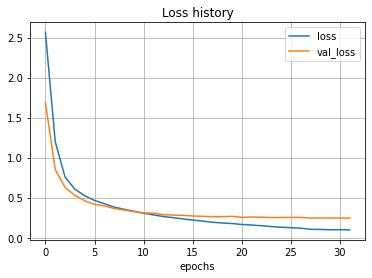

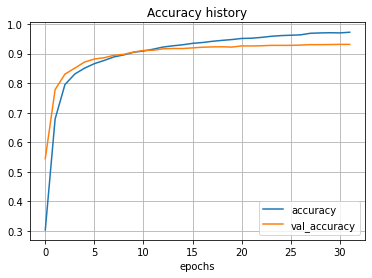

In [71]:
from utils.utils import plot_history

plot_history(second_model_history)

#### Example of predictions on a val sentence

In [47]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(second_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NN IN VBG JJ NN CC NN .


#### Validation f1-score macro (no punctuation)

In [77]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

second_model.load_weights('weigths/secondModel/weightsSecondModel.31-0.25.hdf5')

In [78]:
y_pred_val = np.argmax(second_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.808


## 2.5 Third Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. a time-distributed  Dense layer;
4. a final time-distributed  dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters `latent_dim` and `dropout` have been obtained. Finally, the best value obtained for the hyperparameter `units` of the first Dense layer is $128$.

In [57]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [58]:
third_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 100)         1006100   
                                                                 
 bidirectional_10 (Bidirecti  [(None, None, 256),      234496    
 onal)                        (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 time_distributed_11 (TimeDi  (None, None, 128)        32896     
 stributed)                                                      
                                                           

In [51]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'thirdModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsThirdModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Training

In [52]:
third_model_history = third_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 24s 173ms/step - loss: 2.2020 - accuracy: 0.4321 - val_loss: 1.2011 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 7s 121ms/step - loss: 0.8901 - accuracy: 0.7613 - val_loss: 0.6766 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 7s 117ms/step - loss: 0.6210 - accuracy: 0.8246 - val_loss: 0.5397 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 7s 107ms/step - loss: 0.5201 - accuracy: 0.8499 - val_loss: 0.4756 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 7s 113ms/step - loss: 0.4595 - accuracy: 0.8662 - val_loss: 0.4285 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 7s 110ms/step - loss: 0.4127 - accuracy: 0.8774 - val_loss: 0.3945 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 105ms/step - l

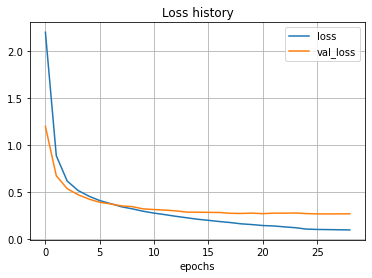

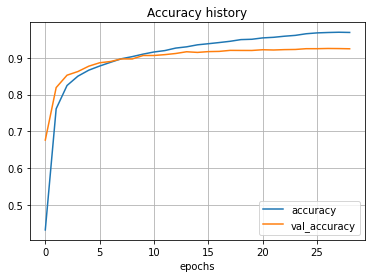

In [53]:
from utils.utils import plot_history

plot_history(third_model_history)

#### Example of predictions on a val sentence

In [54]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(third_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NN IN JJ CD IN NN IN VBG JJ NN CC NN .


#### Validation f1-score macro (no punctuation)

In [59]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

third_model.load_weights('weigths/thirdModel/weightsThirdModel.27-0.27.hdf5')

In [60]:
y_pred_val = np.argmax(third_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.807


# 3 Best model and Error Analysis
In this section, the best model is selected, and an error analysis is performed.

## 3.1 Test score of the two best models
The two best models are the first and second model, since they reach the best f1-score on the validation set. Now, these two models are evaluated on the test set.

In [79]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

first_model.load_weights('weigths/firstModel/weightsFirstModel.26-0.26.hdf5')

In [80]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

second_model.load_weights('weigths/secondModel/weightsSecondModel.31-0.25.hdf5')

#### First model

In [81]:
# Test accuracy 

_, test_accuracy = first_model.evaluate(x_test_padded, y_test_padded)
print(f'Test accuracy first model : {test_accuracy:.2f}')

20/20 [==============================] - 5s 56ms/step - loss: 0.2512 - accuracy: 0.9254
Test accuracy first model : 0.93


In [82]:
# Test f1-score
from utils.evaluate import compute_f1_score

y_pred_test = np.argmax(first_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('Test f1-score macro first model: {:.3f}'.format(f1_macro))

Test f1-score macro first model: 0.856


#### Second model

In [83]:
# Test accuracy 

_, test_accuracy = second_model.evaluate(x_test_padded, y_test_padded)
print(f'Test accuracy second model : {test_accuracy:.2f}')

20/20 [==============================] - 14s 270ms/step - loss: 0.2240 - accuracy: 0.9350
Test accuracy second model : 0.94


In [84]:
# Test f1-score

y_pred_test = np.argmax(second_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('Test f1-score macro second model: {:.3f}'.format(f1_macro))

Test f1-score macro second model: 0.875


## 3.2 Error analysis

The error analysis on the test set is performed for the first model, since it has reached the best validation f1-score macro.

In [24]:
from utils.evaluate import compute_class_report, plot_confusion_matrix, wrongly_classified_tokens_analysis, wrongly_classified_sentences_analysis

In [25]:
# Predictions on the test set

y_test_pred = np.argmax(first_model(x_test_padded), axis=2)

#### Classification report

              precision    recall  f1-score   support

          NN       0.87      0.90      0.88      2383
          IN       0.98      0.96      0.97      1630
         NNP       0.91      0.86      0.88      1501
          DT       0.99      0.99      0.99      1335
         NNS       0.88      0.92      0.90       941
          JJ       0.80      0.81      0.81       916
          CD       0.97      0.99      0.98       858
         VBD       0.92      0.93      0.93       634
          RB       0.79      0.86      0.82       381
          VB       0.96      0.96      0.96       403
          CC       0.99      1.00      0.99       366
          TO       1.00      1.00      1.00       386
         VBN       0.83      0.79      0.81       366
         VBZ       0.94      0.95      0.95       280
         PRP       0.98      0.98      0.98       192
         VBG       0.86      0.81      0.83       221
         VBP       0.89      0.88      0.88       134
          MD       0.95    

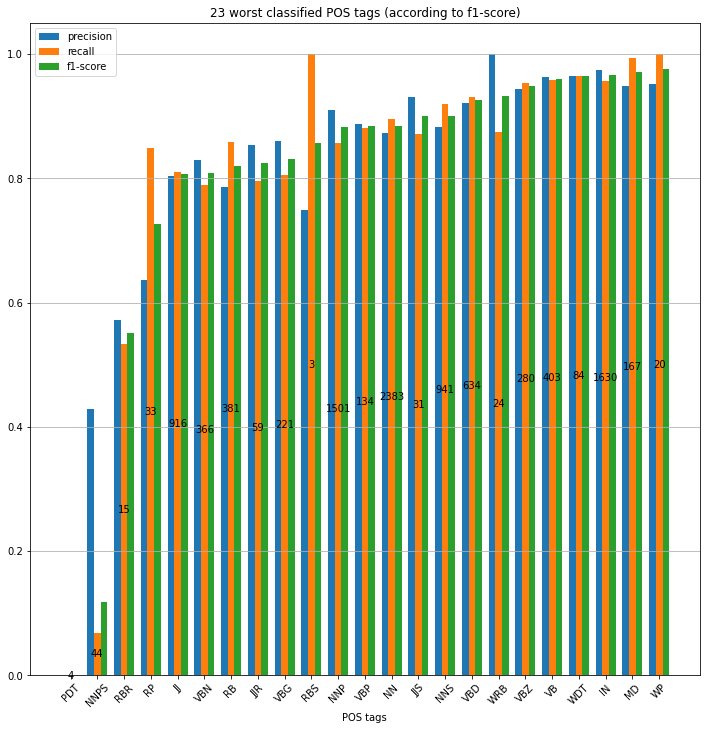

In [26]:
class_report = compute_class_report(y_true=y_test_padded, y_pred=y_test_pred, tags_no_evaluate=tags_no_evaluate, 
                                    vocabulary_labels=vocabulary_labels, show=True, plot=True, k=n_classes//2)

*The numbers inside each bar represents the support of that class.*

First of all, by looking at the classification report, it can be noticed that the classes with highest support are predicted quite well: indeed, all of them have a f1-score above $0.8$.

Furthermore, there are only four classes with a f1-score below $0.8$, namely the classes `PDT`, `NNPS`, `RBR` and `RP`, which are classes with very low support. Regarding these classes, few interesting comments can be made.
- The class `PDT` is never predicted, which is not surprising given its support.
- The class `NNPS` has a precision which is much higher than its recall, meaning that the model has difficulties to recognize tokens with that tag. Instead, the class `RP` exhibits the opposite behaviour: recall higher than the precision.

#### Confusion matrix
Confusion matrix, normalized by row (i.e. by `true`).

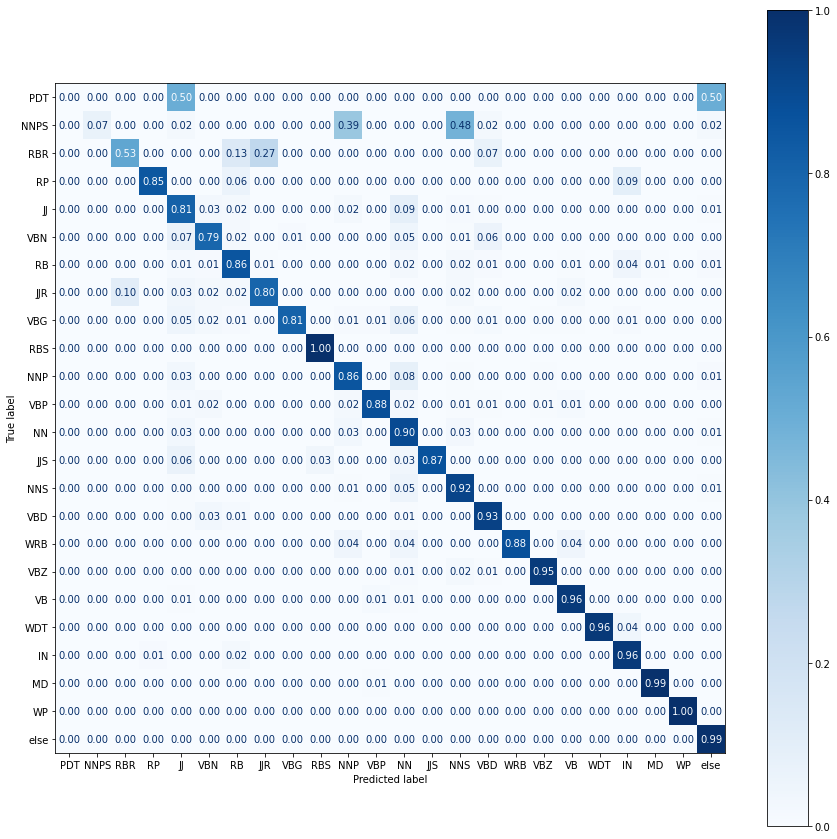

In [27]:
# The worst 23 tags are considered for the confusion matrix
tags = ['PDT', 'NNPS', 'RBR', 'RP', 'JJ', 'VBN', 'RB', 'JJR', 'VBG', 'RBS', 'NNP', 'VBP', 'NN', 'JJS', 'NNS', 'VBD', 'WRB', 
        'VBZ', 'VB', 'WDT', 'IN', 'MD', 'WP']

plot_confusion_matrix(y_true=y_test_padded, y_pred=y_test_pred, tags=tags, tags_no_evaluate=tags_no_evaluate, 
                      vocabulary_labels=vocabulary_labels, normalize='true')

The following comments can be made.

**1) Tag `NNPS`** 

Most of the tokens are predicted either as `NNP` or `NNS`, meaning that the model has difficulties in understanding either the proper form or the plural form. These kinds of errors could be considered as minor errors, since the tags are not so different (e.g. these errors are less important than an error between the classes `NNPS` and `JJ`). Some sentences with high error rate containing mistakes on the class `NNPS` are now shown.

In [32]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             tag='NNPS', vocabulary=vocabulary, show=True, k=3)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified tag of interest
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 149
Relative error: 0.28
`` this market 's[VBZ/POS] still going[VBG/VBP] through its pains[NNS/NN] , '' said philip puccio , head of equity trading at prudential-bache[NNP/JJ] securities[NNPS/NNS] . 

2) Sentence index 48
Relative error: 0.28
one[CD/DT] analyst , arthur stevenson , of prudential-bache[NNP/JJ] securities[NNPS/NNP] , new york , estimated that[IN/DT] [num] % or more of brazil 's newly[RB/VBN] made[VBN/VBD] automobiles run[VBP/VBN] on alcohol and ca n't use gasoline[NN/NNS] . 

3) Sentence index 541
Relative error: 0.27
but the army[NNP/NN] corps[NNP/NN] of engineers[NNPS/NNS] expects the river[NN/NNP] level to continue falling this month . 



**2) Class `RBR` and `JJR`**

Most of the `RBR `tokens are predicted either as `RB` or `JJR`: also in this case, these kinds of errors are minor errors. Some mistakes are now shown.

In [33]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             tag='RBR', vocabulary=vocabulary, show=True, k=3, legend=False)

1) Sentence index 357
Relative error: 0.22
columbia stock recently[RB/VBD] hit[VBD/VBN] [num] [num] , after reaching [num] [num] earlier[RBR/JJR] this year on rumors[NNS/VBG] that mr. spiegel would take the thrift private[JJ/NN] . 

2) Sentence index 605
Relative error: 0.15
still , usx fared[VBD/RB] better[RBR/RB] than other major steelmakers , earning more per[IN/JJ] ton of steel shipped than either[DT/IN] bethlehem steel corp. , which posted a [num] % drop in net income , or inland steel industries[NNPS/NNP] inc. , whose profit[NN/NNS] plummeted [num] % . 

3) Sentence index 608
Relative error: 0.11
charles bradford , an analyst with merrill lynch capital markets[NNPS/NNS] , said usx may have received orders lost[VBN/NN] by competitors who were involved in labor contracts earlier[RBR/JJR] this year . 



A very similar behaviour can be osberved for the `JJR` class, in which several tokens are predicted as `RBR`.

**3) Mistakes involving singular/plural forms**

As pointed out speaking about `NNPS`, the model can have difficulties in discriminating between singular/plural forms of the same part-of-speech. Another example is about the tags `JJS` and `JJ`.

In [34]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             tag='JJS', vocabulary=vocabulary, show=True, k=1, legend=False)

1) Sentence index 324
Relative error: 0.20
economic growth appears to be leveling off[IN/RP] , latest[JJS/JJ] reports suggest . 



**4) Tag `RP`**

Most of the misclassified tokens are predicted either as `IN` or `RB`. Basically, there are cases in which the model struggles in recognizing the particle as part of a phrasal verb (i.e. related to a verb) and it simply considers the usual tag for that token as it is.

In [35]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             tag='RP', vocabulary=vocabulary, show=True, k=5, legend=False)

1) Sentence index 476
Relative error: 0.19
'' programs like section [num] -lrb- a[NN/DT] -rrb- are a little[RB/JJ] like leaving gold in the street and then expressing[VBG/VBD] surprise when thieves walk by[RP/IN] to scoop it up[IN/RP] . 

2) Sentence index 84
Relative error: 0.16
buying for the most[JJS/RBS] part carried[VBD/VBN] over[RP/IN] from the previous session , and traders apparently[RB/VBD] ignored reports that a chilean mine[JJ/NN] strike may have ended almost before it began , an analyst said . 

3) Sentence index 235
Relative error: 0.16
yesterday , carnival said a new company has been formed in finland that will carry on[RP/IN] waertsilae[NNP/NN] 's shipbuilding operations[NNS/NN] . 

4) Sentence index 614
Relative error: 0.13
proceeds of that sale[NN/NNS] are to be used to reduce debt and buy back[RP/RB] shares . 

5) Sentence index 615
Relative error: 0.06
the company noted that it has reduced debt by $ [num] billion since the end of [num] and bought back[RP/RB] about[IN

**5) Examples of other minor understandable errors**

Here some other minor understandable errors are shown.

In [31]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             tag='VBN', vocabulary=vocabulary, show=True, k=5, legend=False)

1) Sentence index 77
Relative error: 0.33
continued[VBN/VBD] export demand also supported[VBD/VBN] prices . 

2) Sentence index 48
Relative error: 0.28
one[CD/DT] analyst , arthur stevenson , of prudential-bache[NNP/JJ] securities[NNPS/NNP] , new york , estimated that[IN/DT] [num] % or more of brazil 's newly[RB/VBN] made[VBN/VBD] automobiles run[VBP/VBN] on alcohol and ca n't use gasoline[NN/NNS] . 

3) Sentence index 412
Relative error: 0.24
metallgesellschaft[NN/NNP] , a diversified frankfurt[NNP/NN] , west germany-based[JJ/NNP] metals[NNS/NNPS] group[NN/NNP] , said it is buying the stake in the specialized[VBN/JJ] engineering company to expand its production of environmental[JJ/NN] supplies for power plants . 

4) Sentence index 413
Relative error: 0.24
lentjes ' product mix of specialized[VBN/JJ] boilers and pipes provides a good[JJ/NN] fit[NN/VBN] with its own lurgi[NNP/NN] g.m.b . 

5) Sentence index 283
Relative error: 0.20
south africa accused[VBD/VBG] armed[VBN/JJ] namibian n

#### Analysis of the worst classified tokens

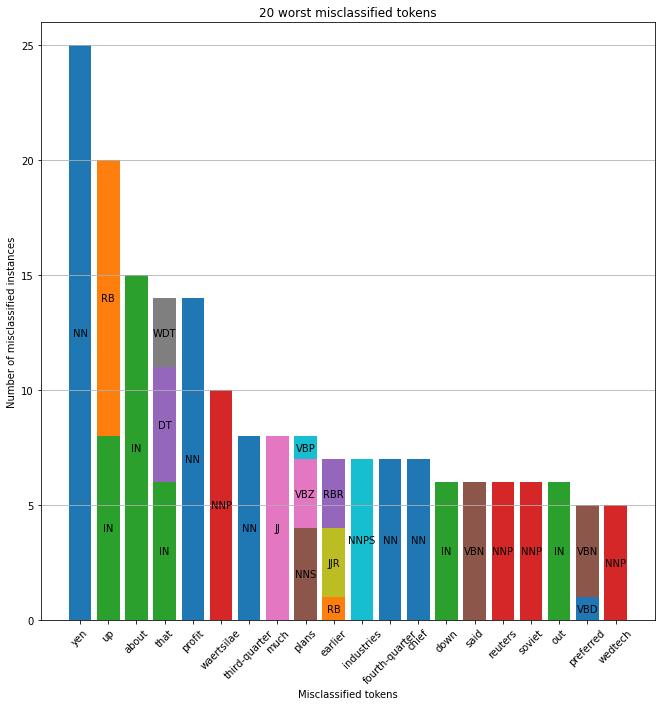

In [36]:
wrong_tokens_dict, wrong_tokens_tags_df = wrongly_classified_tokens_analysis(x=x_test_padded, y_true=y_test_padded, 
                                                                             y_pred=y_test_pred, 
                                                                             tags_no_evaluate=tags_no_evaluate, 
                                                                             vocabulary_labels=vocabulary_labels, 
                                                                             vocabulary=vocabulary, plot=True)

*The colored splitting inside each bar represents the number of different true POS tags for each token.*

The following comments can be made.

**1) Token `yen`**

As the following examples show us, the model has difficulties in discriminating between the singular and plural form of this token. In particular, when this token follows a number, the model predicts `NNS`, while the true tag is `NN`.

In [37]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             token='yen', vocabulary=vocabulary, show=True, k=3, legend=False)

1) Sentence index 352
Relative error: 0.44
dollar : [num] yen[NN/NNS] , up[RB/IN] [num] ; [num] marks[NNS/NN] , up[RB/IN] [num] . 

2) Sentence index 318
Relative error: 0.33
per-share[JJ/NNP] net rose to [num] yen[NN/NNS] from [num] yen[NN/NNS] . 

3) Sentence index 190
Relative error: 0.23
profit[NN/NNS] surged [num] % to [num] billion yen[NN/NNS] , or [num] yen[NN/NNS] a share , from [num] billion yen[NN/NNS] , or [num] yen[NN/NNS] a share . 



**2) Tokens `up`, `that`, `plans`, `earlier`**

These tokens seem to be hard to predict, since they can have different POS tags depending on their usage in the sentence, as shown in the plot above. The following are some examples.

In [38]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             token='up', vocabulary=vocabulary, show=True, k=3, legend=False)

1) Sentence index 352
Relative error: 0.44
dollar : [num] yen[NN/NNS] , up[RB/IN] [num] ; [num] marks[NNS/NN] , up[RB/IN] [num] . 

2) Sentence index 350
Relative error: 0.36
dow jones industrials[NNS/NNP] [num] , up[RB/IN] [num] ; transportation[NN/NNP] [num] , up[RB/IN] [num] ; utilities [num] , up[RB/IN] [num] . 

3) Sentence index 476
Relative error: 0.19
'' programs like section [num] -lrb- a[NN/DT] -rrb- are a little[RB/JJ] like leaving gold in the street and then expressing[VBG/VBD] surprise when thieves walk by[RP/IN] to scoop it up[IN/RP] . 



In [39]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             token='that', vocabulary=vocabulary, show=True, k=3, legend=False)

1) Sentence index 453
Relative error: 0.39
this is a johnson-era[NN/NNP] , great society[NNP/NN] creation[NN/VBG] that[WDT/IN] mandates certain government contracts be[VB/MD] awarded noncompetitively[RB/PRP] to minority[NN/VB] businesses . 

2) Sentence index 48
Relative error: 0.28
one[CD/DT] analyst , arthur stevenson , of prudential-bache[NNP/JJ] securities[NNPS/NNP] , new york , estimated that[IN/DT] [num] % or more of brazil 's newly[RB/VBN] made[VBN/VBD] automobiles run[VBP/VBN] on alcohol and ca n't use gasoline[NN/NNS] . 

3) Sentence index 237
Relative error: 0.20
carnival said the fantasy[NNP/NN] , a 2,050-passenger[JJ/VBD] ship[NN/NNP] that[WDT/IN] was slated to be delivered this month , will be delivered in january . 



**3) Uncommon proper nouns**

As shown in the plot above, some misclassified tokens are proper nouns, e.g. `waertsilae`, `soviet`, ..., which are not common.

In [40]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             token='waertsilae', vocabulary=vocabulary, show=True, k=3, legend=False)

1) Sentence index 497
Relative error: 0.23
carnival , which has three ships on order from waertsilae[NNP/JJ] marine[NNP/NN] , presented[VBD/VBN] claims[NNS/VBZ] for $ [num] billion damages[NNS/NN] in the bankruptcy court this week . 

2) Sentence index 490
Relative error: 0.17
everything[NN/PRP] will be taken over by the new company , '' said christian andersson , executive vice president of oy waertsilae[NNP/NNS] , former parent of waertsilae[NNP/NN] marine[NNP/NN] . 

3) Sentence index 494
Relative error: 0.17
oy waertsilae[NNP/VBZ] is to contribute [num] million markkaa[NN/NNP] , most of it as[IN/RB] subordinated[VBN/JJ] debt , and take a minority stake in the new company . 



#### Analysis of the worst classified sentences

Below are shown the worst classified sentences, by relative and absolute error.

In [41]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             vocabulary=vocabulary, show=True, k=5, legend=False)

1) Sentence index 443
Relative error: 0.50
inter-tel[NNP/NN] inc . 

2) Sentence index 352
Relative error: 0.44
dollar : [num] yen[NN/NNS] , up[RB/IN] [num] ; [num] marks[NNS/NN] , up[RB/IN] [num] . 

3) Sentence index 414
Relative error: 0.43
h.[NN/NNP] plant[NN/NNP] engineering[VBG/NN] unit , the company said . 

4) Sentence index 453
Relative error: 0.39
this is a johnson-era[NN/NNP] , great society[NNP/NN] creation[NN/VBG] that[WDT/IN] mandates certain government contracts be[VB/MD] awarded noncompetitively[RB/PRP] to minority[NN/VB] businesses . 

5) Sentence index 179
Relative error: 0.38
old[NNP/JJ] spaghetti[NNP/CD] warehouse[NNP/NN] rose [num] to [num] [num] . 



In [42]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=True,
                                                             vocabulary=vocabulary, show=True, k=5, legend=False)

1) Sentence index 450
Error count: 9
bribe by bribe , mr. sternberg and his co-author , matthew c. harrison jr. , lead[VBP/JJ] us[PRP/NNP] along the path[NN/JJ] wedtech[NNP/NN] traveled[VBD/RB] , from its inception as a small manufacturing[VBG/NN] company to the status of full-fledged defense contractor , entrusted[VBN/VBG] with the task of producing vital equipment[NN/NNS] for the army[NNP/NN] and navy . 

2) Sentence index 48
Error count: 8
one[CD/DT] analyst , arthur stevenson , of prudential-bache[NNP/JJ] securities[NNPS/NNP] , new york , estimated that[IN/DT] [num] % or more of brazil 's newly[RB/VBN] made[VBN/VBD] automobiles run[VBP/VBN] on alcohol and ca n't use gasoline[NN/NNS] . 

3) Sentence index 156
Error count: 7
'' other rumored[VBN/JJ] takeover and restructuring[VBG/NN] candidates to attract buyers included[VBD/VBN] woolworth , which went up[RB/RP] [num] [num] to [num] [num] ; avon products[NNPS/NNS] , up [num] [num] to [num] [num] ; paramount communications[NNPS/NNS] ,

## 3.3 Comparison with the validation set

In [43]:
# Predictions on the val set

y_val_pred = np.argmax(first_model(x_val_padded), axis=2)

              precision    recall  f1-score   support

          NN       0.85      0.91      0.88      4512
          IN       0.98      0.97      0.97      3275
         NNP       0.90      0.86      0.88      2703
          DT       0.98      0.99      0.99      2754
         NNS       0.91      0.91      0.91      2102
          JJ       0.82      0.79      0.80      1923
          CD       0.97      0.97      0.97      1249
         VBD       0.90      0.93      0.91       861
          RB       0.81      0.88      0.84       951
          VB       0.95      0.89      0.92       956
          CC       1.00      0.98      0.99       757
          TO       1.00      1.00      1.00       765
         VBN       0.83      0.80      0.81       737
         VBZ       0.97      0.94      0.96       712
         PRP       0.99      0.98      0.99       570
         VBG       0.85      0.78      0.81       475
         VBP       0.86      0.89      0.88       460
          MD       0.98    

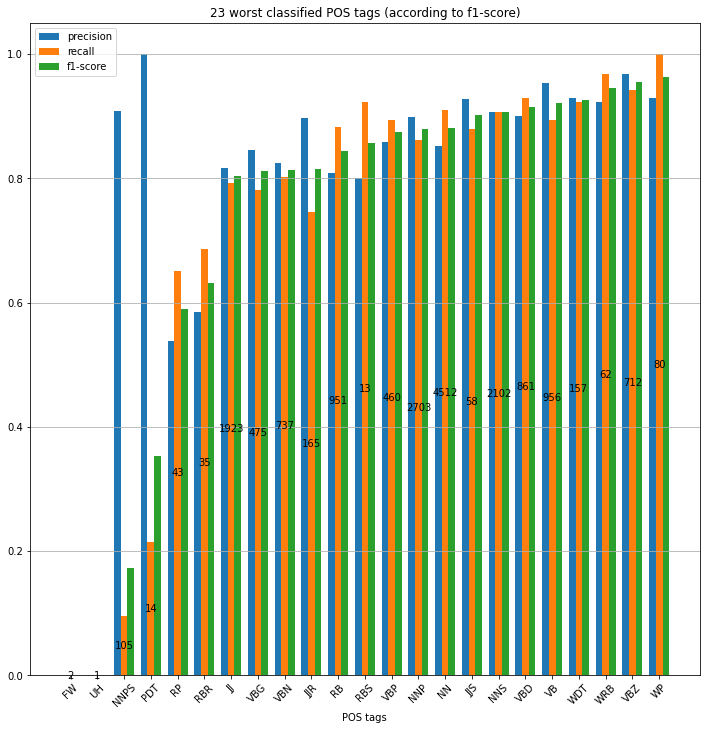

In [44]:
class_report = compute_class_report(y_true=y_val_padded, y_pred=y_val_pred, tags_no_evaluate=tags_no_evaluate, 
                                    vocabulary_labels=vocabulary_labels, show=True, plot=True, k=n_classes//2)

As it can be seen, the overall scores (i.e. accuracy, f1-score macro and weighted) are quite similar. Indeed, also in this case the classes with highest support have a f1-score above $0.8$.

Regarding the classes with f1-score macro below $0.8$, there are still few of them, and they still have very low support. It is interesting to notice also that some of these classes have very high precision and very low recall.

Overall, we can conclude saying that the results on the validation set are coherent with the results on the test set.